In [ ]:
import numpy as np
import os
import random
import glob
import csv
import time
from scipy.signal import welch, firwin, filtfilt

# Parameters
jamming_duration_ratio = 0.25
wideband_ratio = 0.5  # 50% del ancho de banda de la señal
narrowband_ratio = 0.005  # 0.5% del ancho de banda de la señal

FS = 12e6  # Sample rate in Hz
FC = 498e6  # Center frequency in Hz
NFFT = 1024

# Input and output directories
input_directory = "../Capturas_B2101/Capturas/Capturas_clean"
output_directory = "../Capturas_B2101/Capturas/Jamming"
os.makedirs(output_directory, exist_ok=True)
output_directory_clean = os.path.join(output_directory, "Clean")
output_directory_wideband = os.path.join(output_directory, "Wideband")
output_directory_narrowband = os.path.join(output_directory, "Narrowband")
os.makedirs(output_directory_clean, exist_ok=True)
os.makedirs(output_directory_wideband, exist_ok=True)
os.makedirs(output_directory_narrowband, exist_ok=True)

# Metadata CSV file setup
metadata_file = os.path.join(output_directory, "metadata.csv")

with open(metadata_file, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    # Write initial metadata for FS, FC, and NFFT
    csv_writer.writerow(["SampleRate", "CenterFrequency", "NFFT"])
    csv_writer.writerow([FS, FC, NFFT])
    csv_writer.writerow([])  # Empty line for separation
    csv_writer.writerow(
        ["FileName", "SignalType", "JammingStartTime", "AveragePower_dB"]
    )

# Get .bin files
file_list = glob.glob(os.path.join(input_directory, "*.data"))

output_files = []
jamming_start_times = []  # To store t0 values for histogram

def generate_lpf_noise(cutoff: float = 0.25, N: int = 2000, fs: float = 1):

    # Design filter
    b = firwin(61, cutoff=cutoff, window="hamming", fs=fs)

    # Generate noise
    Es = 1
    SNR = 0
    noiseVar = Es / np.power(10, (SNR / 10))
    noise = np.sqrt(noiseVar / 2) * (np.random.randn(N) + 1j * np.random.randn(N))

    output = filtfilt(b, 1, noise)

    return output

for file_path in file_list:
    # Load data
    with open(file_path, "rb") as file:
        data = np.frombuffer(file.read(), dtype=np.complex64)

    num_samples = len(data)

    # Verify sample count
    if num_samples != 50000:
        print(
            f"Error: {file_path} no contiene 50,000 muestras (contiene {num_samples})."
        )
        continue

    # Calculate PSD and max power
    f, Pxx_spec = welch(
        data, fs=FS, nperseg=NFFT, return_onesided=False, scaling="density"
    )
    PSD_signal = 10 * np.log10(Pxx_spec)
    max_PSD = np.max(PSD_signal)
    avg_power_dB = 10 * np.log10(np.mean(np.abs(data) ** 2))

    # Save clean (original) signal with original name
    output_file_clean = os.path.join(
        output_directory_clean, os.path.basename(file_path)
    )

    with open(output_file_clean, "wb") as out_file:
        out_file.write(data.astype(np.complex64).tobytes())

    # Write metadata for clean signal
    with open(metadata_file, mode="a", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([os.path.basename(file_path), "Clean", -1, avg_power_dB])

    output_files.append(output_file_clean)

    # Define ISR levels and create jamming signals
    ISR_wide = random.uniform(3, 13)
    ISR_to_apply_wide = max_PSD + ISR_wide + 10 * np.log10(FS)
    gain_factor_wide = np.sqrt(10 ** (ISR_to_apply_wide / 10))
    jamming_signal_wide = gain_factor_wide * generate_lpf_noise(
        cutoff=2e6, N=50000, fs=FS
    )

    ISR_narrow = random.uniform(6, 16)
    ISR_to_apply_narrow = max_PSD + ISR_narrow + 10 * np.log10(FS)
    gain_factor_narrow = np.sqrt(10 ** (ISR_to_apply_narrow / 10))
    jamming_signal_narrow = gain_factor_narrow * generate_lpf_noise(
        cutoff=0.2e6, N=50000, fs=FS
    )

    # Jamming parameters
    jamming_samples = int(num_samples * jamming_duration_ratio)
    t0 = random.randint(
        int(num_samples * 0.25), int(num_samples * 0.75) - jamming_samples
    )

    # Apply jamming and save files
    for jamming_type, jamming_signal, output_dir in [
        ("Wideband", jamming_signal_wide, output_directory_wideband),
        ("Narrowband", jamming_signal_narrow, output_directory_narrowband),
    ]:
        # Adjust jamming signal length
        jamming_signal = np.pad(
            jamming_signal, (0, max(0, jamming_samples - len(jamming_signal)))
        )[:jamming_samples]

        # Create interfered signal
        interfered_signal = np.copy(data)
        interfered_signal[t0 : t0 + jamming_samples] += jamming_signal

        # Verify length
        if len(interfered_signal) != 50000:
            print(
                f"Error: Archivo interferido {file_path} tiene {len(interfered_signal)} muestras."
            )
            continue

        # Define file naming
        timestamp = int(time.time() * 1e6)
        signal_type_label = f"DVBT{jamming_type}Jamming"
        output_file_name = f"{int(FC / 1e3):09}_{int(FS / 1e3):09}_{num_samples:09}_{timestamp}_{signal_type_label}.data"
        output_file = os.path.join(output_dir, output_file_name)

        # Save interfered file
        with open(output_file, "wb") as out_file:
            out_file.write(interfered_signal.astype(np.complex64).tobytes())

        # Write metadata
        with open(metadata_file, mode="a", newline="") as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([output_file_name, jamming_type, t0, avg_power_dB])

        print(f"Archivo guardado: {output_file}")
        output_files.append(output_file)

        # Add t0 to the list for histogram
        jamming_start_times.append(t0)

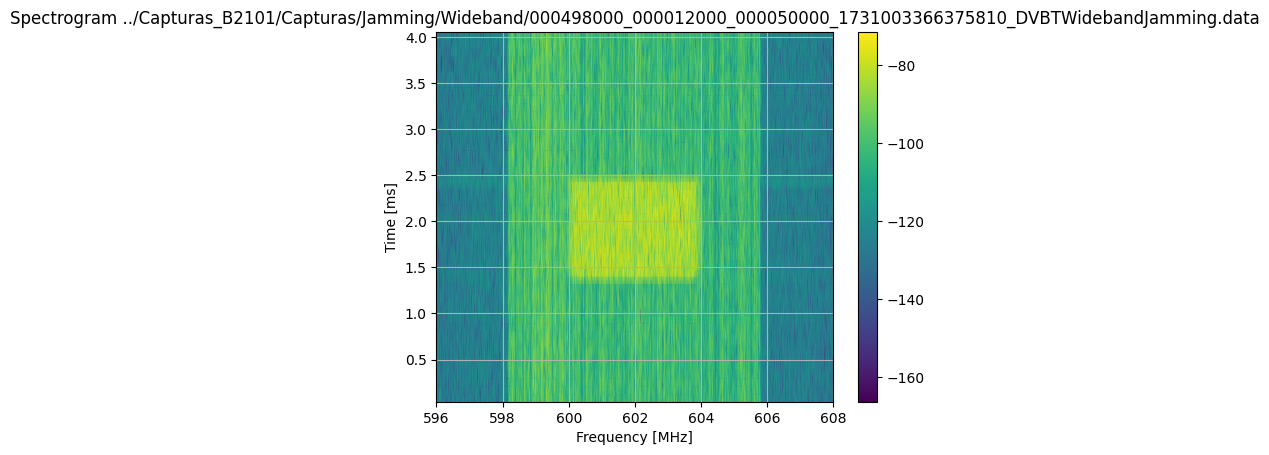

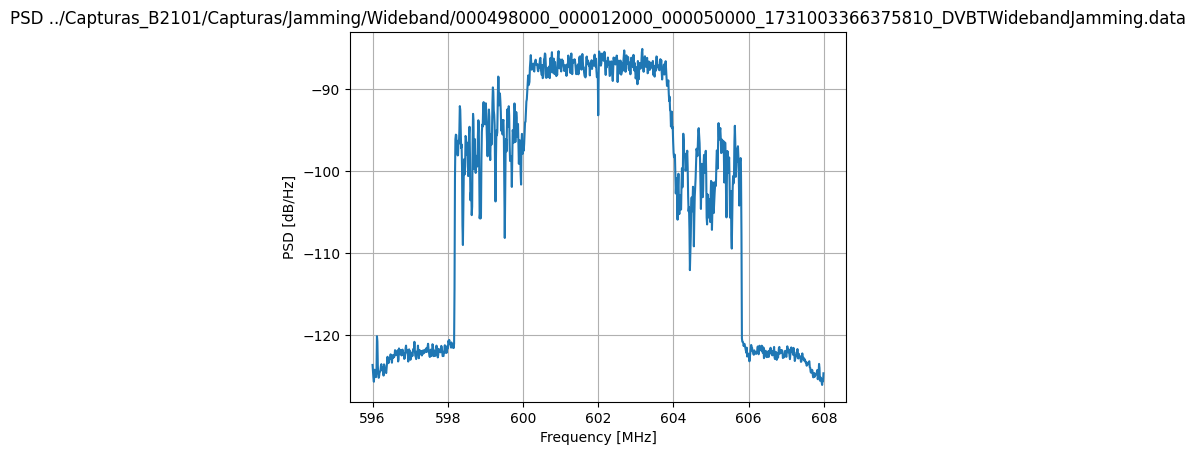

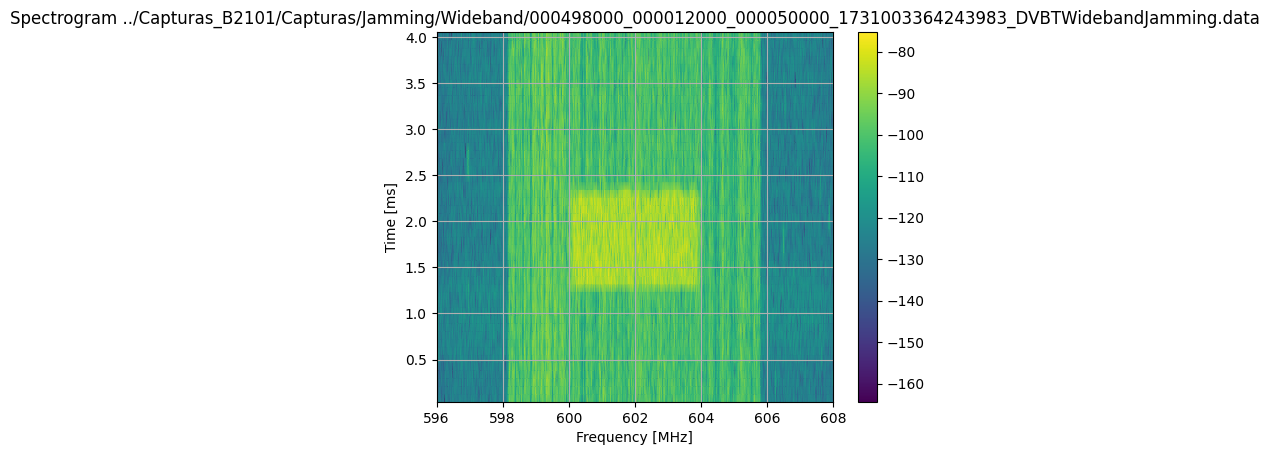

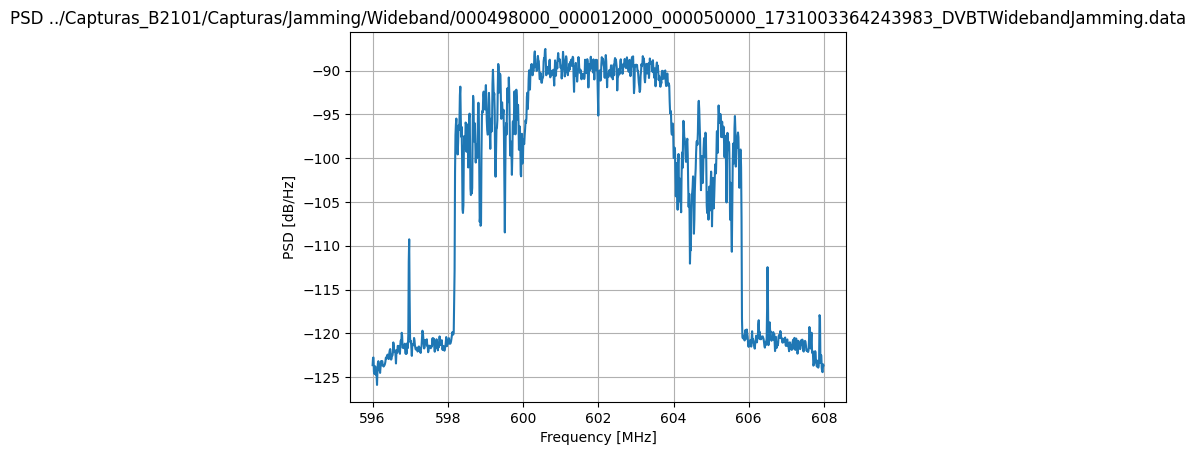

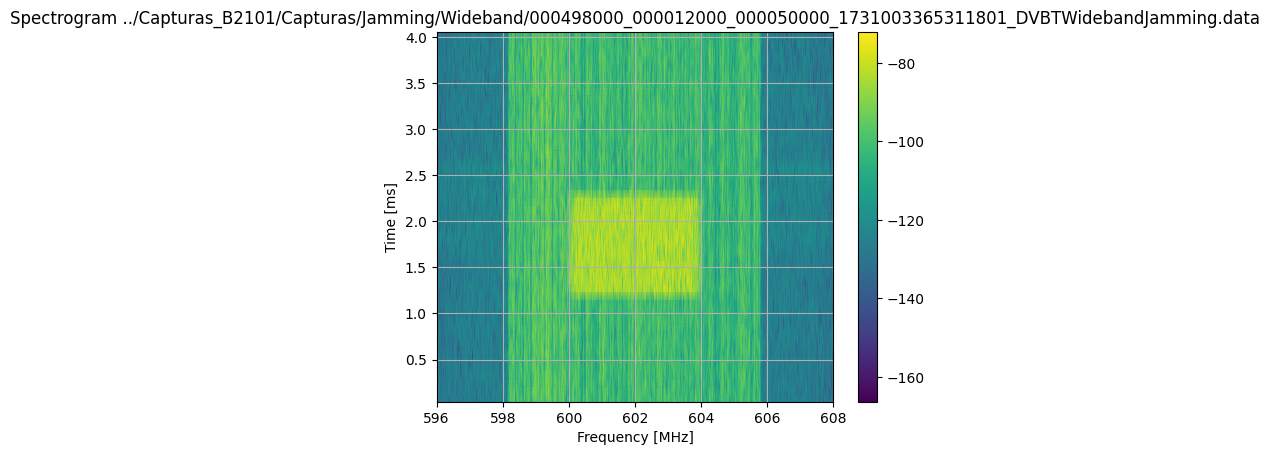

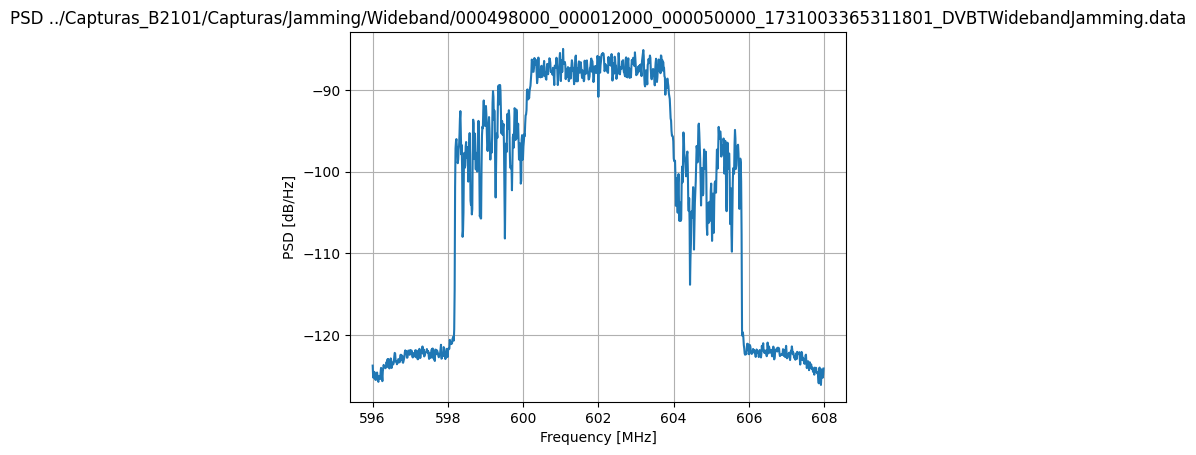

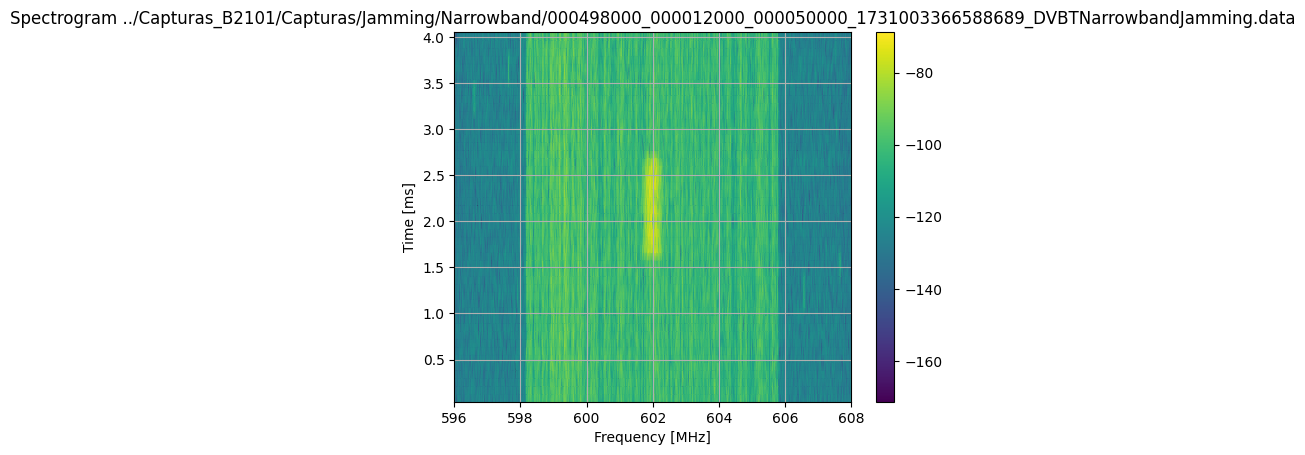

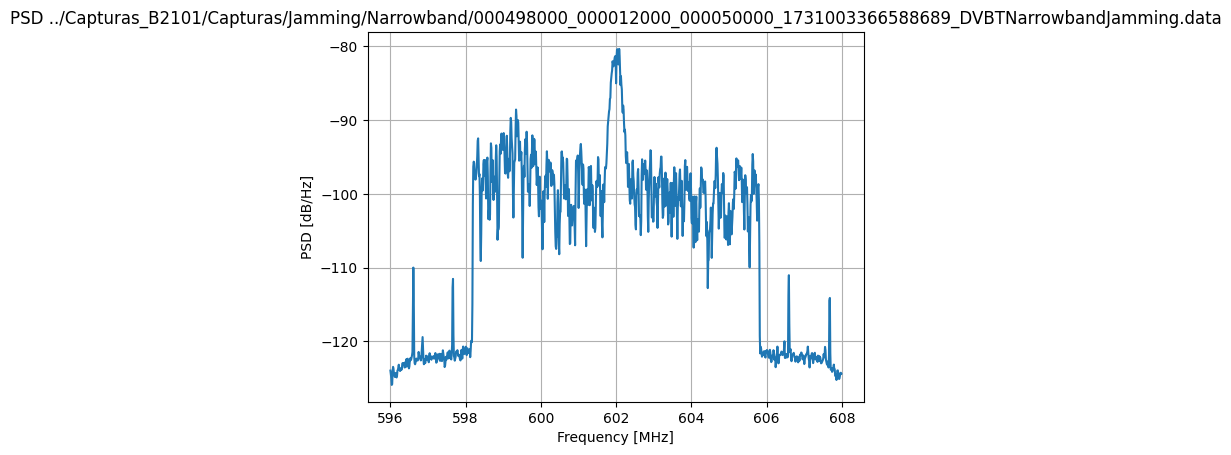

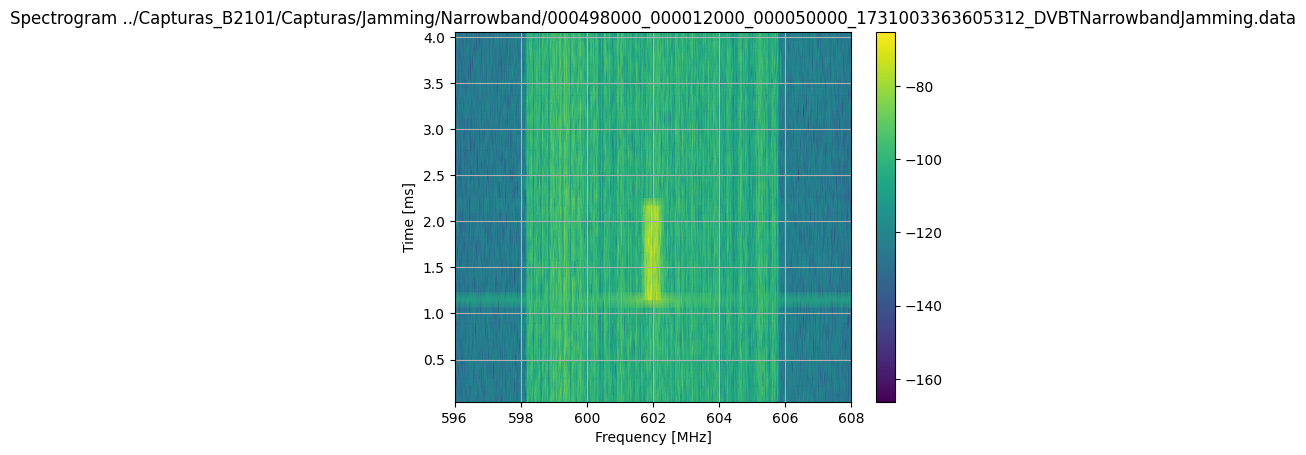

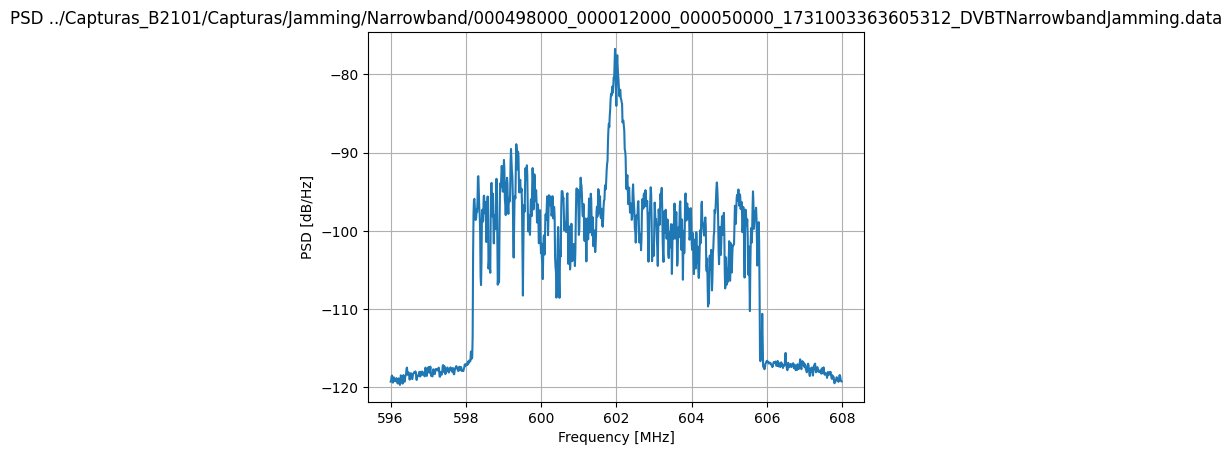

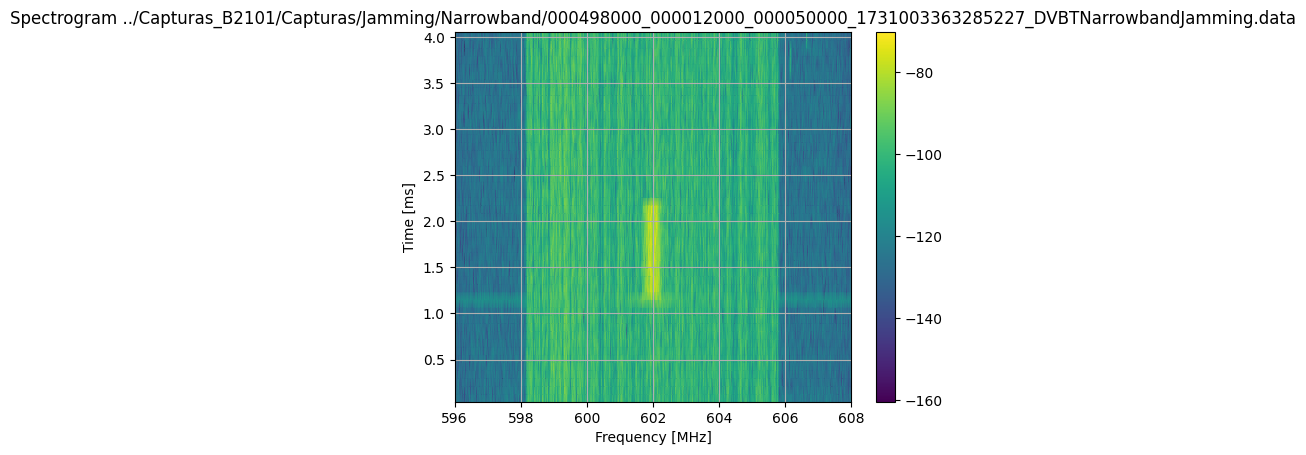

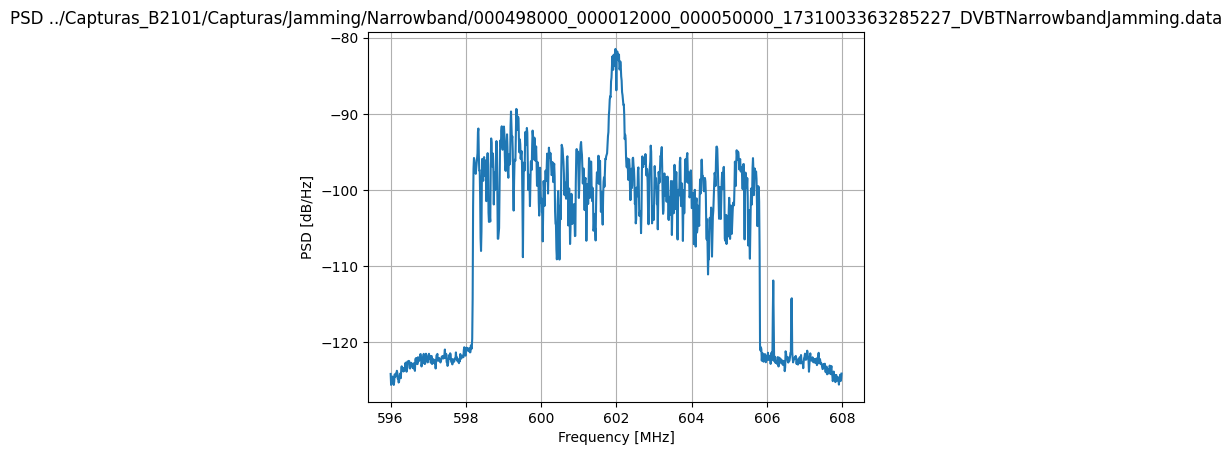

In [ ]:
import numpy as np
import os
import random
import glob
import matplotlib.pyplot as plt
from scipy.fft import fftshift
from scipy.signal import welch, spectrogram

# Functions required for plotting the PSD and spectrogram

def plot_PSD(signal, fs=1.0, title="", nfft=256, fc=0.0):

    f, Pxx_spec = welch(signal, fs, nperseg=nfft, return_onesided=False, scaling="density")
    Pxx_spec_dB = 10 * np.log10(Pxx_spec)
    f = fftshift(f)
    Pxx_spec_dB = fftshift(Pxx_spec_dB)

    fig, ax = plt.subplots()
    ax.plot((f + fc) / 1e6, Pxx_spec_dB)
    ax.set_xlabel("Frequency [MHz]")
    ax.set_ylabel("PSD [dB/Hz]")
    ax.set_title(title)
    ax.grid(True)

    return fig


def plot_spectrogram(
    signal_to_plot,
    fs=1.0,
    nfft=512,
    noverlap=0,
    return_onesided=False,
    title="",
    fc=0.0,
):
    fig, ax1 = plt.subplots()

    f, t, Sxx = spectrogram(
        signal_to_plot,
        fs,
        nperseg=nfft,
        noverlap=noverlap,
        return_onesided=return_onesided,
    )
    Sxx_dB = 10 * np.log10(Sxx)

    im = ax1.pcolormesh(
        ((fftshift(f) + fc) / (1e6)),
        (t * 1e3),
        fftshift(Sxx_dB.T, axes=1),
        shading="gouraud",
    )
    ax1.set(
        xlabel="Frequency [MHz]",
        ylabel="Time [ms]",
        title="Power spectral density [dB/Hz]",
        xlim=((fc - fs / 2) / 1e6, (fc + fs / 2) / 1e6),
    )
    ax1.grid(True)
    fig.colorbar(im, ax=ax1)

    plt.title(title)

    return fig

# Input and output directories
base_directory = "../Capturas_B2101/Capturas/Jamming"
subfolders = ["Clean", "Wideband", "Narrowband"]

# Iterate over subfolders and process 3 random files from each
for subfolder in subfolders:
    folder_path = os.path.join(base_directory, subfolder)
    file_paths = glob.glob(os.path.join(folder_path, "*.data"))  # Assuming files are .data

    random_files = random.sample(file_paths, min(3, len(file_paths)))  # Select 3 random files

    for file_path in random_files:
        with open(file_path, "rb") as file:
            signal = np.frombuffer(file.read(), dtype=np.complex64)

        # Define FS, NFFT, and FC (Example values)
        FS = 12e6  # Example: 12 MHz sample rate
        NFFT = 1024  # Example: FFT size
        FC = 602e6  # Example: 602 MHz center frequency

        # Plot Spectrogram and PSD
        fig = plot_spectrogram(signal, FS, NFFT, title=f"Spectrogram {file_path}", fc=FC)
        fig = plot_PSD(signal, FS, title=f"PSD {file_path}", nfft=NFFT, fc=FC)
